Getting started
============

This is a quick overview of multiple capabilities of ``pvfactors``:

- using the engine to run timeseries simulations
- plot a PV array
- inspect the results of a simulation using a PV array object
- inspect the results of a simulation using a report function

Imports and settings

In [1]:
# Import external libraries
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

# Settings
%matplotlib inline
np.set_printoptions(precision=3, linewidth=300)

### Get timeseries inputs

In [2]:
df_inputs = pd.DataFrame(
    {'solar_zenith': [20., 50.],
     'solar_azimuth': [110., 250.],
     'surface_tilt': [10., 20.],
     'surface_azimuth': [90., 270.],
     'dni': [1000., 300.],
     'dhi': [50., 500.],
     'albedo': [0.2, 0.2]}, 
    index=[datetime(2017, 8, 31, 11), datetime(2017, 8, 31, 15)]
)
df_inputs

,solar_zenith,solar_azimuth,surface_tilt,surface_azimuth,dni,dhi,albedo
2017-08-31 11:00:00,20.0,110.0,10.0,90.0,1000.0,50.0,0.2
2017-08-31 15:00:00,50.0,250.0,20.0,270.0,300.0,500.0,0.2


### Prepare PV array parameters

In [3]:
pvarray_parameters = {
    'n_pvrows': 3,            # number of pv rows
    'pvrow_height': 1,        # height of pvrows (measured at center / torque tube)
    'pvrow_width': 1,         # width of pvrows
    'axis_azimuth': 0.,       # azimuth angle of rotation axis
    'gcr': 0.4,               # ground coverage ratio
    'rho_front_pvrow': 0.01,  # pv row front surface reflectivity
    'rho_back_pvrow': 0.03    # pv row back surface reflectivity
}

### Run simulations with pvfactors

Use the ``PVEngine`` and the ``OrderedPVArray`` to run simulations

In [4]:
from pvfactors.engine import PVEngine
from pvfactors.geometry import OrderedPVArray

# Create an ordered PV array
pvarray = OrderedPVArray.init_from_dict(pvarray_parameters)
# Create engine
engine = PVEngine(pvarray)
# Fit engine to data
engine.fit(df_inputs.index, df_inputs.dni, df_inputs.dhi, 
           df_inputs.solar_zenith, df_inputs.solar_azimuth, 
           df_inputs.surface_tilt, df_inputs.surface_azimuth, 
           df_inputs.albedo)

The user can run a simulation for a single timestep and plot the returned PV array

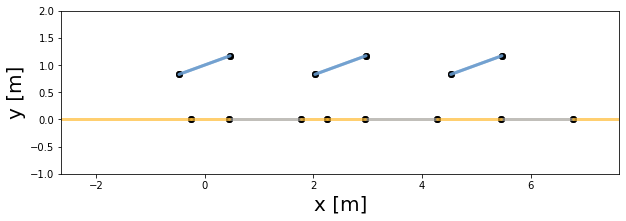

In [5]:
# Get pvarray at given timestamp
pvarray = engine.run_timestep(idx=1)

# Plot pvarray shapely geometries
f, ax = plt.subplots(figsize=(10, 3))
pvarray.plot(ax)
plt.show()

The user can inspect the results very easily thanks to the simple geometry API

In [6]:
# Get the calculated outputs from the pv array
center_row_front_incident_irradiance = pvarray.pvrows[1].front.get_param_weighted('qinc')
left_row_back_reflected_incident_irradiance = pvarray.pvrows[0].back.get_param_weighted('reflection')
right_row_back_isotropic_incident_irradiance = pvarray.pvrows[2].back.get_param_weighted('isotropic')

print("Incident irradiance on front surface of middle pv row: %.2f W/m2"
      % center_row_front_incident_irradiance)
print("Reflected irradiance on back surface of left pv row: %.2f W/m2"
      % left_row_back_reflected_incident_irradiance)
print("Isotropic irradiance on back surface of right pv row: %.2f W/m2"
      % right_row_back_isotropic_incident_irradiance)

Incident irradiance on front surface of middle pv row: 811.66 W/m2
Reflected irradiance on back surface of left pv row: 90.25 W/m2
Isotropic irradiance on back surface of right pv row: 9.28 W/m2


The users can also run simulations for all timestamps, and obtain a "report" that is entirely custom-made, and which will rely on the simple geometry API shown above.
Here is an example:

In [7]:
# Create a function that will build a report
from pvfactors.report import example_fn_build_report

# Run full simulation
report = engine.run_all_timesteps(fn_build_report=example_fn_build_report)

# Print results (report is defined by report function passed by user)
df_report = pd.DataFrame(report, index=df_inputs.index)
df_report

100%|██████████| 2/2 [00:00<00:00, 30.03it/s]


,qinc_front,qinc_back,iso_front,iso_back
2017-08-31 11:00:00,1034.967753,106.627832,20.848345,0.115792
2017-08-31 15:00:00,811.659036,85.535537,276.181750,6.304878


As already shown, the calculated incident irradiance on the front surface of the center PV row for the second timestamp is 811.66 W/m2.